---
title: 'Deep Learning in TS'
execute:
  echo: false
format:
  revealjs:
    slide-number: true
    smaller: false
    embed-resources: true
    theme:
      - default
      - custom.scss
    toc: false
    smooth-scroll: false
    code-fold: false
    scrollable: true
    incremental: false
    code-copy: true
    chalkboard: false
    preview-links: false
    pdf-separate-fragments: true
---

In [1]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import regularizers

In [2]:
# read in meta dataset
meta = pd.read_csv("./data/yahoo/tech/META.csv")
# convert date column to datetime
meta['Date'] = pd.to_datetime(meta['Date'])
# keep only date and adjusted closing price columns
meta = meta.drop(columns=["Open", "High", "Low", "Close", "Volume"])
meta.to_csv('meta.csv', index=False)
meta.head()

,Date,Adj Close
0,2012-06-01,31.100000
1,2012-07-01,21.709999
2,2012-08-01,18.059999
3,2012-09-01,21.660000
4,2012-10-01,21.110001


In [3]:
# define a function to split train and test to 70-30
def split_train_test(data, percent=0.7):
    df = pd.read_csv(data, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    split = int(n*percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

In [4]:
# define a function to convert data into X and Y arrarys
def convert_XY(data, time_steps):
    Y_range = np.arange(time_steps, len(data), time_steps)
    Y = data[Y_range]
    X = data[range(time_steps * len(Y))]
    X = np.reshape(X, (len(Y), time_steps, 1))
    return X, Y

In [5]:
# define a function to calcualte RMSE between predicted value and actual value
def get_rmse(y_train, y_test, train_pred, test_pred):
    train_rmse = math.sqrt(np.square(np.subtract(y_train, train_pred)).mean())
    test_rmse = math.sqrt(np.square(np.subtract(y_test, test_pred)).mean())
    print("Train RMSE =", round(train_rmse, 4))
    print("Test RMSE =", round(test_rmse, 4)) 
    return train_rmse, test_rmse

In [6]:
# define a SimpleRNN model function
def create_RNN(hidden_units, dense_units, input_shape, activation, kernel_regularizer = None, shuffle = True):
    model = Sequential()
    # create a simple neural network layer
    model.add(SimpleRNN(hidden_units, 
              input_shape = input_shape, 
              activation = activation[0]))
    # add one dense layer to the model
    model.add(Dense(units=dense_units,
              activation = activation[1],
              kernel_regularizer = kernel_regularizer))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [7]:
# define a LSTM model function
def create_LSTM(hidden_units, dense_units, input_shape, activation, kernel_regularizer = None, shuffle = True):
    model = Sequential()
    # create a simple neural network layer
    model.add(LSTM(hidden_units, 
              input_shape = input_shape, 
              activation = activation[0]))
    # add one dense layer to the model
    model.add(Dense(units=dense_units,
              activation = activation[1],
              kernel_regularizer = kernel_regularizer))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [8]:
# define a GRU model function
def create_GRU(hidden_units, dense_units, input_shape, activation, kernel_regularizer = None, shuffle = True):
    model = Sequential()
    # create a simple neural network layer
    model.add(GRU(hidden_units, 
              input_shape = input_shape, 
              activation = activation[0]))
    # add one dense layer to the model
    model.add(Dense(units=dense_units,
              activation = activation[1],
              kernel_regularizer = kernel_regularizer))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [9]:
df_meta = ('meta.csv')
train_data, test_data, data = split_train_test(df_meta)
#print(data)
#print(train_data)
#print(test_data)
x_train, y_train = convert_XY(train_data, 1)
x_test, y_test = convert_XY(test_data, 1)
#print(x_train)
#print(y_train)
#print(y_test)
#print(x_test)

In [10]:
# define a function to plot actual and predicted values
def get_plot(y_train, y_test, train_pred, test_pred):
    actual = np.append(y_train, y_test)
    pred = np.append(train_pred, test_pred)
    plt.figure(figsize=(10,5))
    plt.plot(range(len(actual)), actual)
    plt.plot(range(len(actual)), pred)
    plt.legend(['Actual', 'Predicted'])
    plt.xlabel("Time Steps")
    plt.ylabel("Adjusted Closing Price (scaled)")
    plt.title("META Actual vs. Predicted Adjusted Closing Prices Over Time")
    plt.show()

In [11]:
def plot_model(history, model_title):
    print('History', history.history)
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.title(f'Training loss ({model_title})')
    plt.legend()

In [31]:
rnn = create_RNN(hidden_units=3, 
                 dense_units=1, 
                 input_shape=(1,1), 
                 activation=['tanh', 'tanh'],
                 shuffle = True)

lstm = create_LSTM(hidden_units=3, 
                   dense_units=1, 
                   input_shape=(1,1), 
                   activation=['tanh', 'tanh'],
                   shuffle = True)

gru = create_GRU(hidden_units=3, 
                 dense_units=1, 
                 input_shape=(1,1), 
                 activation=['tanh', 'tanh'],
                 shuffle = True)

In [33]:
rnn_reg = create_RNN(hidden_units=3, 
                     dense_units=1, 
                     input_shape=(1,1), 
                     activation=['tanh', 'tanh'], 
                     kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))

lstm_reg = create_LSTM(hidden_units=3, 
                     dense_units=1, 
                     input_shape=(1,1), 
                     activation=['tanh', 'tanh'], 
                     kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))

gru_reg = create_GRU(hidden_units=3, 
                     dense_units=1, 
                     input_shape=(1,1), 
                     activation=['tanh', 'tanh'], 
                     kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
                

In [15]:
# first model: rnn without regularization
rnn_history = rnn.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)
rnn_train_pred = rnn.predict(x_train)
rnn_test_pred = rnn.predict(x_test)

train_rmse, test_rmse = get_rmse(y_train, y_test, rnn_train_pred, rnn_test_pred)

Epoch 1/20


2023-04-29 12:01:49.986730: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


88/88 - 1s - loss: 0.0058 - 975ms/epoch - 11ms/step
Epoch 2/20
88/88 - 1s - loss: 0.0023 - 596ms/epoch - 7ms/step
Epoch 3/20
88/88 - 1s - loss: 0.0015 - 535ms/epoch - 6ms/step
Epoch 4/20
88/88 - 1s - loss: 9.7151e-04 - 534ms/epoch - 6ms/step
Epoch 5/20
88/88 - 1s - loss: 7.2307e-04 - 535ms/epoch - 6ms/step
Epoch 6/20
88/88 - 1s - loss: 6.5718e-04 - 533ms/epoch - 6ms/step
Epoch 7/20
88/88 - 1s - loss: 6.4828e-04 - 537ms/epoch - 6ms/step
Epoch 8/20
88/88 - 1s - loss: 6.1131e-04 - 533ms/epoch - 6ms/step
Epoch 9/20
88/88 - 1s - loss: 6.1126e-04 - 659ms/epoch - 7ms/step
Epoch 10/20
88/88 - 1s - loss: 6.3183e-04 - 537ms/epoch - 6ms/step
Epoch 11/20
88/88 - 1s - loss: 6.0404e-04 - 528ms/epoch - 6ms/step
Epoch 12/20
88/88 - 1s - loss: 6.1829e-04 - 533ms/epoch - 6ms/step
Epoch 13/20
88/88 - 1s - loss: 6.1584e-04 - 538ms/epoch - 6ms/step
Epoch 14/20
88/88 - 1s - loss: 6.1154e-04 - 579ms/epoch - 7ms/step
Epoch 15/20
88/88 - 1s - loss: 6.3224e-04 - 579ms/epoch - 7ms/step
Epoch 16/20
88/88 - 1s - l

In [16]:
rmse_table = {
    'model' : ['RNN'],
    'training_rmse': [train_rmse],
    'testing_rmse': [test_rmse]
}

History {'loss': [0.005831943824887276, 0.002297698287293315, 0.001453535514883697, 0.0009715101332403719, 0.000723070465028286, 0.000657177937682718, 0.0006482780445367098, 0.0006113124545663595, 0.0006112554692663252, 0.0006318296073004603, 0.0006040404550731182, 0.0006182897486723959, 0.0006158354226499796, 0.0006115399883128703, 0.0006322423578239977, 0.0006234465399757028, 0.0006424414459615946, 0.0006104930653236806, 0.0006527052610181272, 0.0006219333154149354]}


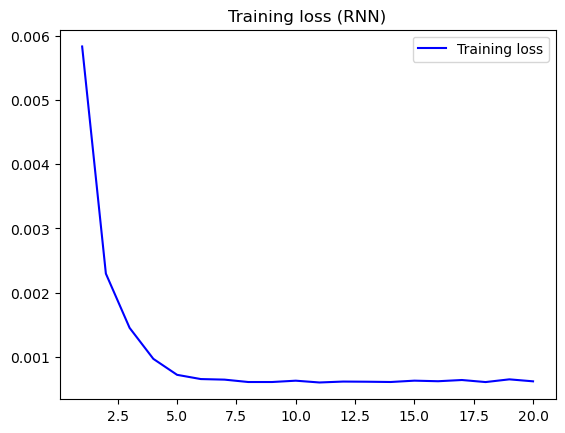

In [17]:
plot_model(rnn_history, 'RNN')

In [18]:
# second model: rnn with regularization
rnn_reg_history = rnn_reg.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)
rnn_reg_train_pred = rnn_reg.predict(x_train)
rnn_reg_test_pred = rnn_reg.predict(x_test)

train_rmse, test_rmse = get_rmse(y_train, y_test, rnn_reg_train_pred, rnn_reg_test_pred)

Epoch 1/20
88/88 - 1s - loss: 0.0079 - 1s/epoch - 14ms/step
Epoch 2/20
88/88 - 1s - loss: 0.0038 - 782ms/epoch - 9ms/step
Epoch 3/20
88/88 - 1s - loss: 0.0028 - 782ms/epoch - 9ms/step
Epoch 4/20
88/88 - 1s - loss: 0.0019 - 775ms/epoch - 9ms/step
Epoch 5/20
88/88 - 1s - loss: 0.0015 - 776ms/epoch - 9ms/step
Epoch 6/20
88/88 - 1s - loss: 0.0012 - 914ms/epoch - 10ms/step
Epoch 7/20
88/88 - 1s - loss: 0.0010 - 781ms/epoch - 9ms/step
Epoch 8/20
88/88 - 1s - loss: 9.2051e-04 - 785ms/epoch - 9ms/step
Epoch 9/20
88/88 - 1s - loss: 8.9828e-04 - 791ms/epoch - 9ms/step
Epoch 10/20
88/88 - 1s - loss: 8.8132e-04 - 797ms/epoch - 9ms/step
Epoch 11/20
88/88 - 1s - loss: 8.2604e-04 - 775ms/epoch - 9ms/step
Epoch 12/20
88/88 - 1s - loss: 8.9550e-04 - 786ms/epoch - 9ms/step
Epoch 13/20
88/88 - 1s - loss: 8.5530e-04 - 777ms/epoch - 9ms/step
Epoch 14/20
88/88 - 1s - loss: 8.7719e-04 - 886ms/epoch - 10ms/step
Epoch 15/20
88/88 - 1s - loss: 9.2123e-04 - 776ms/epoch - 9ms/step
Epoch 16/20
88/88 - 1s - loss: 8

In [19]:
rmse_table['model'].append('RNN with Regularization')
rmse_table['training_rmse'].append(train_rmse)
rmse_table['testing_rmse'].append(test_rmse)

History {'loss': [0.007897593080997467, 0.0038318599108606577, 0.0027827376034110785, 0.0019473194843158126, 0.0015007711481302977, 0.0011719267349690199, 0.0010132604511454701, 0.0009205096866935492, 0.0008982833824120462, 0.0008813213207758963, 0.0008260380127467215, 0.0008955039666034281, 0.0008552983053959906, 0.0008771882858127356, 0.000921228202059865, 0.0008397315978072584, 0.0009073031833395362, 0.0008682390325702727, 0.0008633708930574358, 0.00090238475240767]}


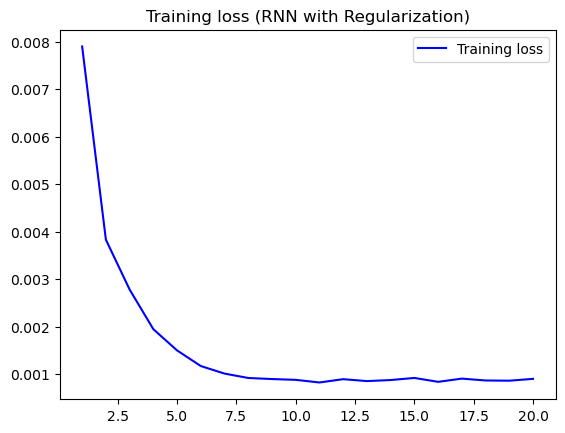

In [20]:
plot_model(rnn_reg_history, 'RNN with Regularization')

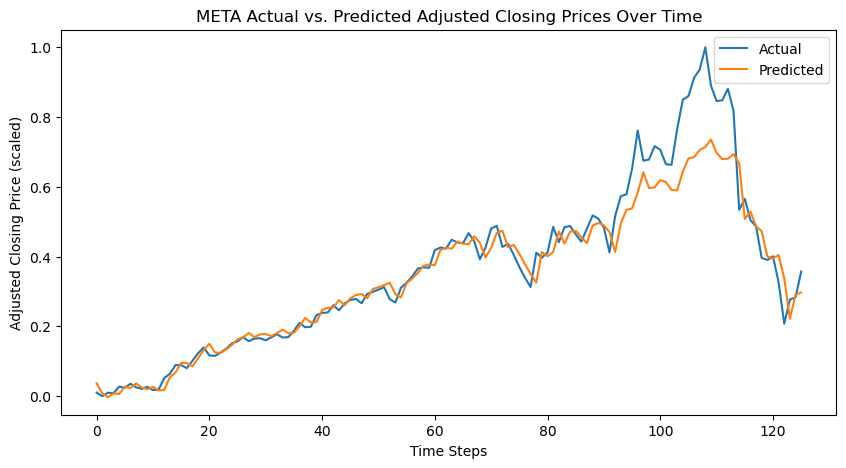

In [21]:
get_plot(y_train, y_test, rnn_reg_train_pred, rnn_reg_test_pred)

In [22]:
# third model: lstm without regularization
lstm_history = lstm.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)
lstm_train_pred = lstm.predict(x_train)
lstm_test_pred = lstm.predict(x_test)
train_rmse, test_rmse = get_rmse(y_train, y_test, lstm_train_pred, lstm_test_pred)

Epoch 1/20
88/88 - 1s - loss: 0.0787 - 1s/epoch - 12ms/step
Epoch 2/20
88/88 - 0s - loss: 0.0408 - 439ms/epoch - 5ms/step
Epoch 3/20
88/88 - 0s - loss: 0.0263 - 416ms/epoch - 5ms/step
Epoch 4/20
88/88 - 0s - loss: 0.0218 - 420ms/epoch - 5ms/step
Epoch 5/20
88/88 - 0s - loss: 0.0202 - 431ms/epoch - 5ms/step
Epoch 6/20
88/88 - 0s - loss: 0.0186 - 420ms/epoch - 5ms/step
Epoch 7/20
88/88 - 0s - loss: 0.0173 - 420ms/epoch - 5ms/step
Epoch 8/20
88/88 - 0s - loss: 0.0162 - 430ms/epoch - 5ms/step
Epoch 9/20
88/88 - 0s - loss: 0.0149 - 418ms/epoch - 5ms/step
Epoch 10/20
88/88 - 0s - loss: 0.0137 - 422ms/epoch - 5ms/step
Epoch 11/20
88/88 - 0s - loss: 0.0123 - 416ms/epoch - 5ms/step
Epoch 12/20
88/88 - 0s - loss: 0.0109 - 419ms/epoch - 5ms/step
Epoch 13/20
88/88 - 0s - loss: 0.0097 - 425ms/epoch - 5ms/step
Epoch 14/20
88/88 - 0s - loss: 0.0085 - 493ms/epoch - 6ms/step
Epoch 15/20
88/88 - 0s - loss: 0.0072 - 441ms/epoch - 5ms/step
Epoch 16/20
88/88 - 0s - loss: 0.0061 - 423ms/epoch - 5ms/step
Epo

In [23]:
rmse_table['model'].append('LSTM')
rmse_table['training_rmse'].append(train_rmse)
rmse_table['testing_rmse'].append(test_rmse)

History {'loss': [0.07874732464551926, 0.04082471504807472, 0.02633199840784073, 0.02179383672773838, 0.020184380933642387, 0.01860940083861351, 0.01733957603573799, 0.016184918582439423, 0.01493634283542633, 0.013677220791578293, 0.012263818643987179, 0.010903622955083847, 0.009657162241637707, 0.008477815426886082, 0.007238632068037987, 0.006065512076020241, 0.005031802225857973, 0.004055844619870186, 0.003305652644485235, 0.002591558266431093]}


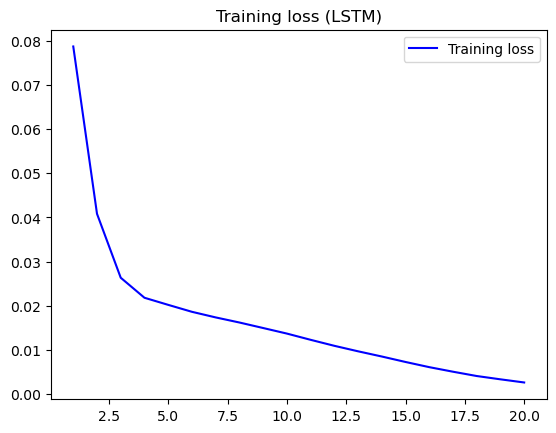

In [24]:
plot_model(lstm_history, 'LSTM')

In [25]:
# fourth model: lstm with regularization
lstm_reg_history = lstm_reg.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)
lstm_reg_train_pred = lstm_reg.predict(x_train)
lstm_reg_test_pred = lstm_reg.predict(x_test)

train_rmse, test_rmse = get_rmse(y_train, y_test, lstm_reg_train_pred, lstm_reg_test_pred)

Epoch 1/20
88/88 - 1s - loss: 0.0759 - 1s/epoch - 16ms/step
Epoch 2/20
88/88 - 1s - loss: 0.0458 - 656ms/epoch - 7ms/step
Epoch 3/20
88/88 - 1s - loss: 0.0317 - 652ms/epoch - 7ms/step
Epoch 4/20
88/88 - 1s - loss: 0.0257 - 647ms/epoch - 7ms/step
Epoch 5/20
88/88 - 1s - loss: 0.0234 - 712ms/epoch - 8ms/step
Epoch 6/20
88/88 - 1s - loss: 0.0219 - 657ms/epoch - 7ms/step
Epoch 7/20
88/88 - 1s - loss: 0.0205 - 656ms/epoch - 7ms/step
Epoch 8/20
88/88 - 1s - loss: 0.0190 - 653ms/epoch - 7ms/step
Epoch 9/20
88/88 - 1s - loss: 0.0172 - 650ms/epoch - 7ms/step
Epoch 10/20
88/88 - 1s - loss: 0.0154 - 654ms/epoch - 7ms/step
Epoch 11/20
88/88 - 1s - loss: 0.0135 - 656ms/epoch - 7ms/step
Epoch 12/20
88/88 - 1s - loss: 0.0115 - 664ms/epoch - 8ms/step
Epoch 13/20
88/88 - 1s - loss: 0.0096 - 656ms/epoch - 7ms/step
Epoch 14/20
88/88 - 1s - loss: 0.0078 - 658ms/epoch - 7ms/step
Epoch 15/20
88/88 - 1s - loss: 0.0061 - 652ms/epoch - 7ms/step
Epoch 16/20
88/88 - 1s - loss: 0.0047 - 708ms/epoch - 8ms/step
Epo

In [26]:
rmse_table['model'].append('LSTM with Regularization')
rmse_table['training_rmse'].append(train_rmse)
rmse_table['testing_rmse'].append(test_rmse)

History {'loss': [0.07586665451526642, 0.04578658565878868, 0.031721606850624084, 0.025735478848218918, 0.023437948897480965, 0.02191799506545067, 0.020478079095482826, 0.018988605588674545, 0.017229901626706123, 0.015398562885820866, 0.01345580443739891, 0.011518926359713078, 0.00962114054709673, 0.007762196473777294, 0.006122002378106117, 0.004728751257061958, 0.0036264939699321985, 0.002627456095069647, 0.0019810860976576805, 0.0015138037269935012]}


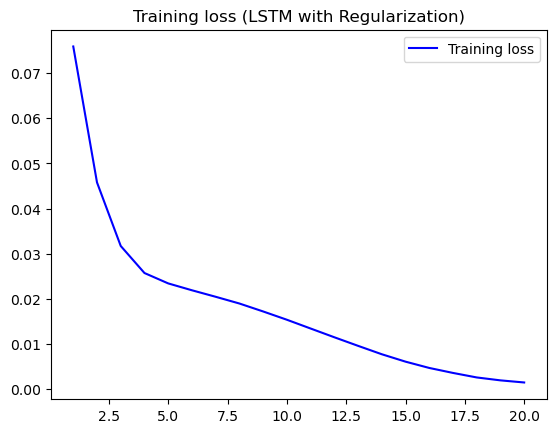

In [27]:
plot_model(lstm_reg_history, 'LSTM with Regularization')

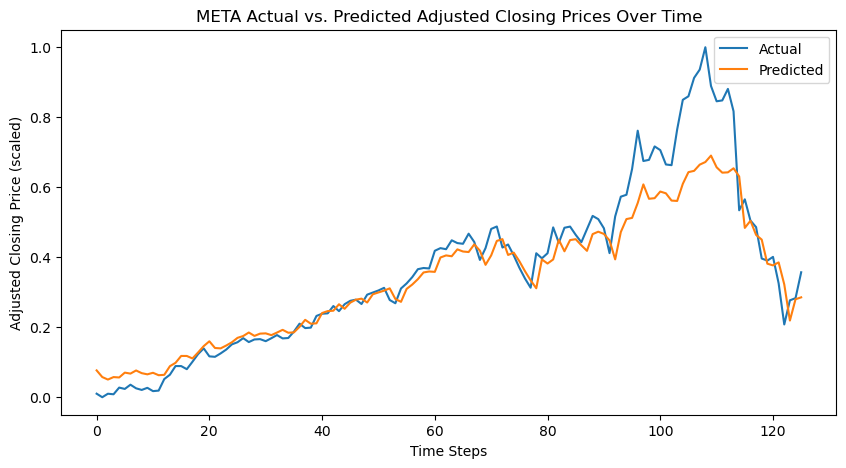

In [28]:
get_plot(y_train, y_test, lstm_reg_train_pred, lstm_reg_test_pred)

In [34]:
# fifth model: gru without regularization
gru_history = gru.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)
gru_train_pred = gru.predict(x_train)
gru_test_pred = gru.predict(x_test)

train_rmse, test_rmse = get_rmse(y_train, y_test, gru_train_pred, gru_test_pred)

Epoch 1/20
88/88 - 1s - loss: 0.0805 - 938ms/epoch - 11ms/step
Epoch 2/20
88/88 - 0s - loss: 0.0432 - 414ms/epoch - 5ms/step
Epoch 3/20
88/88 - 0s - loss: 0.0271 - 393ms/epoch - 4ms/step
Epoch 4/20
88/88 - 0s - loss: 0.0221 - 411ms/epoch - 5ms/step
Epoch 5/20
88/88 - 0s - loss: 0.0203 - 425ms/epoch - 5ms/step
Epoch 6/20
88/88 - 0s - loss: 0.0192 - 460ms/epoch - 5ms/step
Epoch 7/20
88/88 - 0s - loss: 0.0181 - 399ms/epoch - 5ms/step
Epoch 8/20
88/88 - 0s - loss: 0.0169 - 406ms/epoch - 5ms/step
Epoch 9/20
88/88 - 0s - loss: 0.0157 - 409ms/epoch - 5ms/step
Epoch 10/20
88/88 - 0s - loss: 0.0145 - 459ms/epoch - 5ms/step
Epoch 11/20
88/88 - 0s - loss: 0.0132 - 426ms/epoch - 5ms/step
Epoch 12/20
88/88 - 0s - loss: 0.0119 - 408ms/epoch - 5ms/step
Epoch 13/20
88/88 - 0s - loss: 0.0107 - 410ms/epoch - 5ms/step
Epoch 14/20
88/88 - 0s - loss: 0.0093 - 419ms/epoch - 5ms/step
Epoch 15/20
88/88 - 0s - loss: 0.0079 - 392ms/epoch - 4ms/step
Epoch 16/20
88/88 - 0s - loss: 0.0065 - 397ms/epoch - 5ms/step


In [35]:
rmse_table['model'].append('GRU')
rmse_table['training_rmse'].append(train_rmse)
rmse_table['testing_rmse'].append(test_rmse)

History {'loss': [0.0804871916770935, 0.043245550245046616, 0.027066348120570183, 0.022101063281297684, 0.020323866978287697, 0.019205866381525993, 0.01808484084904194, 0.016928456723690033, 0.015710145235061646, 0.014510718174278736, 0.013234546408057213, 0.011915230192244053, 0.010690251365303993, 0.009318063966929913, 0.007873253896832466, 0.006503114011138678, 0.005274894647300243, 0.004139408934861422, 0.0031227944418787956, 0.0023066324647516012]}


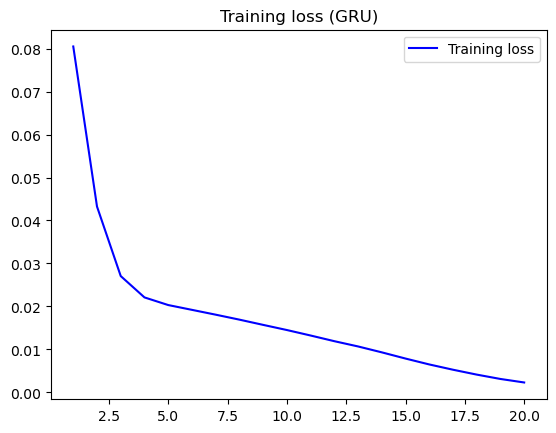

In [36]:
plot_model(gru_history, 'GRU')

In [37]:
# sixth model: gru with regularization
gru_reg_history = gru_reg.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)
gru_reg_train_pred = gru_reg.predict(x_train)
gru_reg_test_pred = gru_reg.predict(x_test)

train_rmse, test_rmse = get_rmse(y_train, y_test, gru_reg_train_pred, gru_reg_test_pred)

Epoch 1/20
88/88 - 1s - loss: 0.0144 - 1s/epoch - 17ms/step
Epoch 2/20
88/88 - 1s - loss: 0.0061 - 702ms/epoch - 8ms/step
Epoch 3/20
88/88 - 1s - loss: 0.0049 - 648ms/epoch - 7ms/step
Epoch 4/20
88/88 - 1s - loss: 0.0039 - 648ms/epoch - 7ms/step
Epoch 5/20
88/88 - 1s - loss: 0.0030 - 654ms/epoch - 7ms/step
Epoch 6/20
88/88 - 1s - loss: 0.0024 - 640ms/epoch - 7ms/step
Epoch 7/20
88/88 - 1s - loss: 0.0018 - 643ms/epoch - 7ms/step
Epoch 8/20
88/88 - 1s - loss: 0.0015 - 645ms/epoch - 7ms/step
Epoch 9/20
88/88 - 1s - loss: 0.0013 - 648ms/epoch - 7ms/step
Epoch 10/20
88/88 - 1s - loss: 0.0011 - 646ms/epoch - 7ms/step
Epoch 11/20
88/88 - 1s - loss: 0.0010 - 650ms/epoch - 7ms/step
Epoch 12/20
88/88 - 1s - loss: 0.0011 - 717ms/epoch - 8ms/step
Epoch 13/20
88/88 - 1s - loss: 9.9913e-04 - 639ms/epoch - 7ms/step
Epoch 14/20
88/88 - 1s - loss: 0.0010 - 635ms/epoch - 7ms/step
Epoch 15/20
88/88 - 1s - loss: 9.7864e-04 - 632ms/epoch - 7ms/step
Epoch 16/20
88/88 - 1s - loss: 9.9856e-04 - 747ms/epoch - 

In [38]:
rmse_table['model'].append('GRU with Regularization')
rmse_table['training_rmse'].append(train_rmse)
rmse_table['testing_rmse'].append(test_rmse)

History {'loss': [0.014434131793677807, 0.006103427615016699, 0.004863247741013765, 0.003871574066579342, 0.0030393933411687613, 0.0023711039684712887, 0.0018391493940725923, 0.0015020265709608793, 0.001334099331870675, 0.0011476915096864104, 0.0010395972058176994, 0.0010519372299313545, 0.0009991308907046914, 0.0010179484961554408, 0.000978639000095427, 0.0009985648794099689, 0.0009841746650636196, 0.001011948101222515, 0.0009752546902745962, 0.0010207713348791003]}


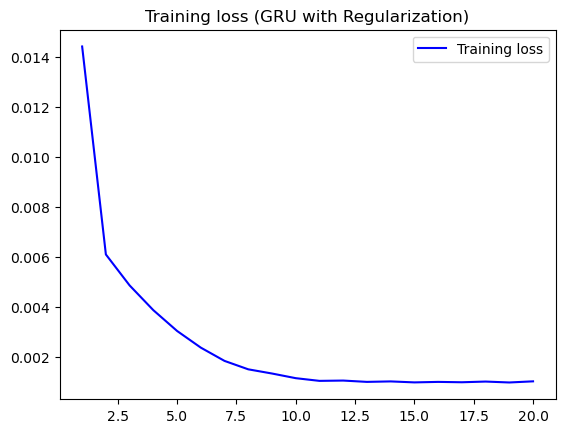

In [39]:
plot_model(gru_reg_history, 'GRU with Regularization')

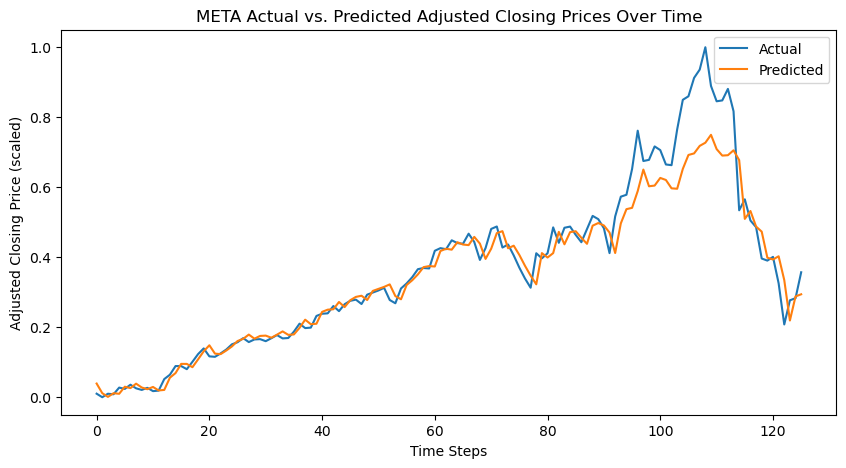

In [40]:
get_plot(y_train, y_test, gru_reg_train_pred, gru_reg_test_pred)

In [43]:
table = pd.DataFrame(rmse_table)
table.to_csv('rmse_table.csv', index=False)
print(table)

                      model  training_rmse  testing_rmse
0                       RNN       0.214814      0.254119
1   RNN with Regularization       0.214255      0.255805
2                      LSTM       0.188151      0.270094
3  LSTM with Regularization       0.199529      0.260465
4                       GRU       0.191244      0.264721
5   GRU with Regularization       0.213596      0.257164
